<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/Purcell%20Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 18.8 MB/s eta 0:00:00


In [47]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# Without Purcell Filter

## Hamiltonian & System Setting

$ H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger) $

$ H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_d t ) } $

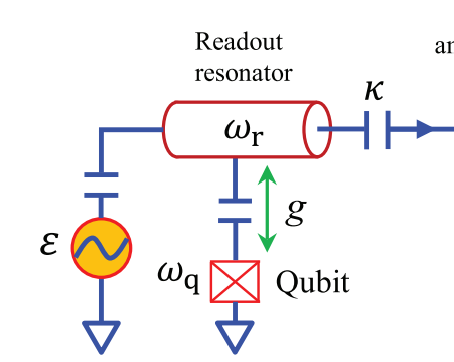

In [96]:
# constant
N = 5

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01    # external coupling rate of resonator in units of GHz

In [97]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))


H0 = -0.5*omega_q*tensor(sz, qeye(N)) + omega_r*tensor(qeye(2), a.dag()*a) + g*tensor(sx, a + a.dag())

In [98]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

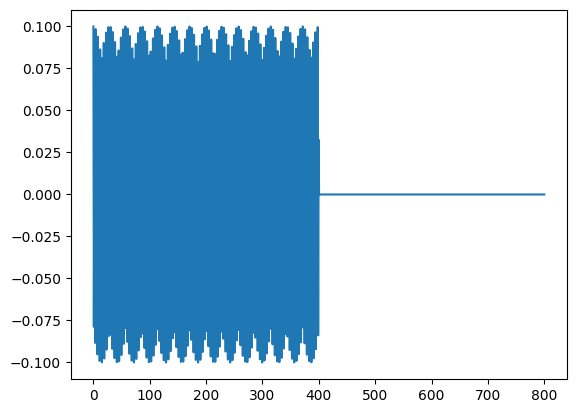

In [99]:
# list of times for numerical simulation (in units of ns)
tlist = np.linspace(0, 800, 1000)
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 400, 'omega_rd': omega_rd}))

## Time Evolution & Purcell Decay Rate

$n=0.23$

In [55]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag()), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 0.01 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.2294269055141213

Text(0, 0.5, 'Photon Number Expectation Value')

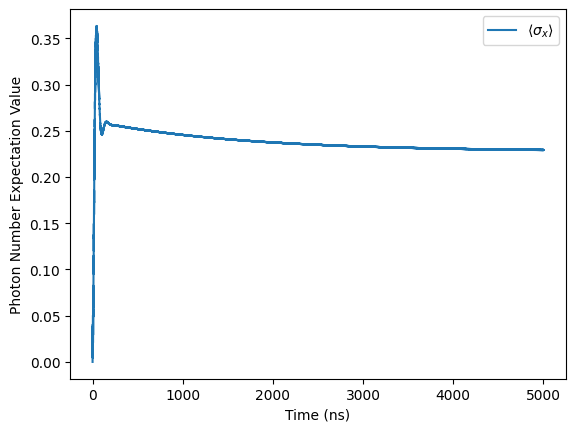

In [56]:
# Plot Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle\sigma_x\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

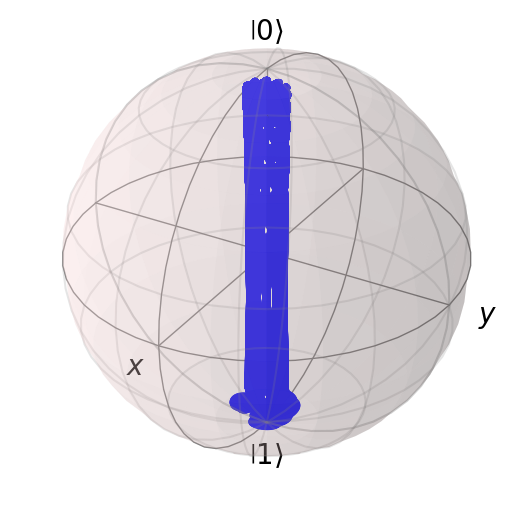

In [57]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

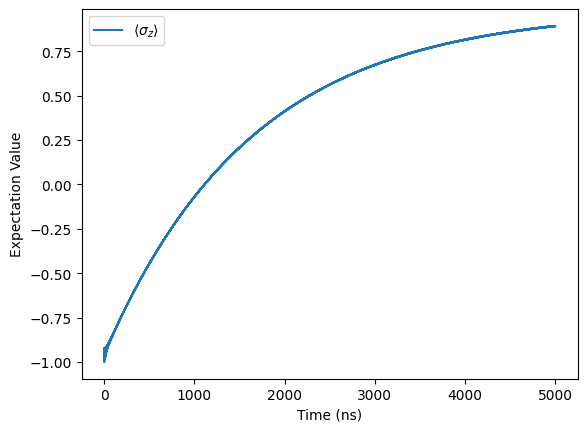

In [58]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [65]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.94050834e+00,  9.83417385e-01,  1.63749690e+03])

## Time Evolution & Purcell Decay Rate

$n=0.0023$

In [100]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag()), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 0.001 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.0028341395379163498

Text(0, 0.5, 'Photon Number Expectation Value')

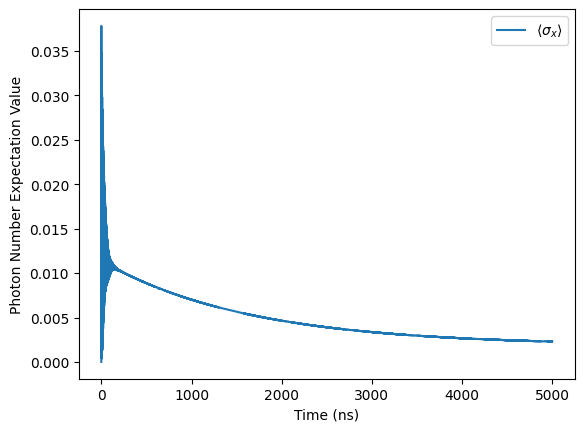

In [92]:
# Plot Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle\sigma_x\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

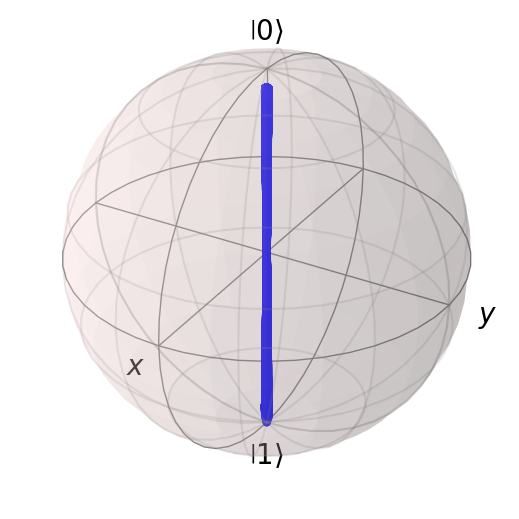

In [93]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

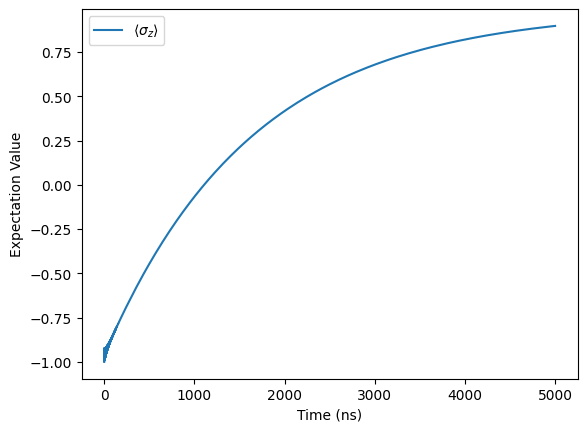

In [94]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [95]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.94935608e+00,  9.87968128e-01,  1.62957304e+03])

# With Linear Purcell Filter

## Hamiltonian & System Setting

$ H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + \omega_f b^\dagger b + g(\sigma_+a+\sigma_-a^\dagger) + G(a b^\dagger + a^\dagger b)$

$ H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t ) } $

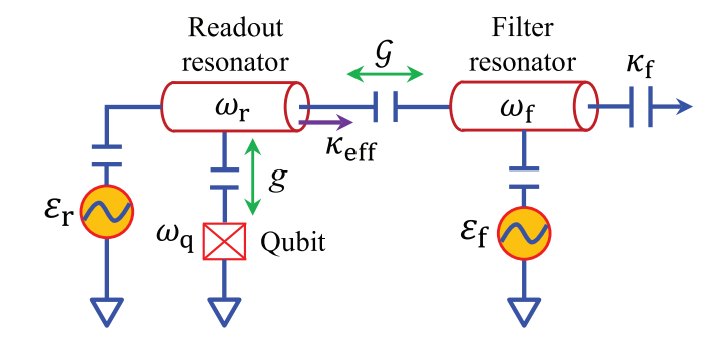

In [113]:
# constant
N = 2

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.2         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

In [114]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))

In [115]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

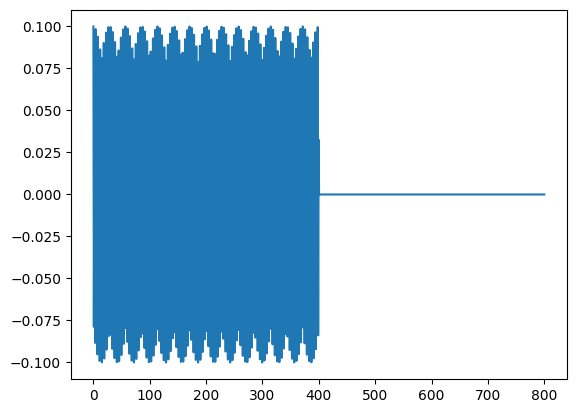

In [116]:
# list of times for numerical simulation (in units of ns)
tlist = np.linspace(0, 800, 1000)
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 400, 'omega_rd': omega_rd}))

## Time Evolution & Purcell Decay Rate

$n=0.40$

In [134]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.1 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.4085568310511106

Text(0, 0.5, 'Photon Number Expectation Value')

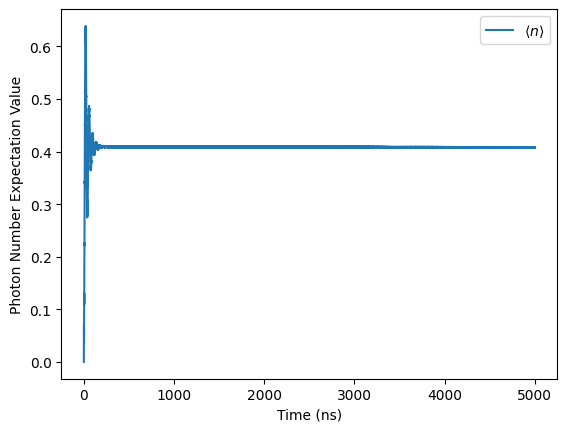

In [135]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

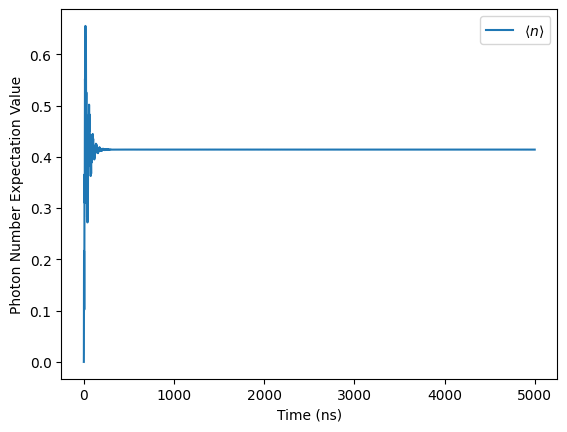

In [136]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

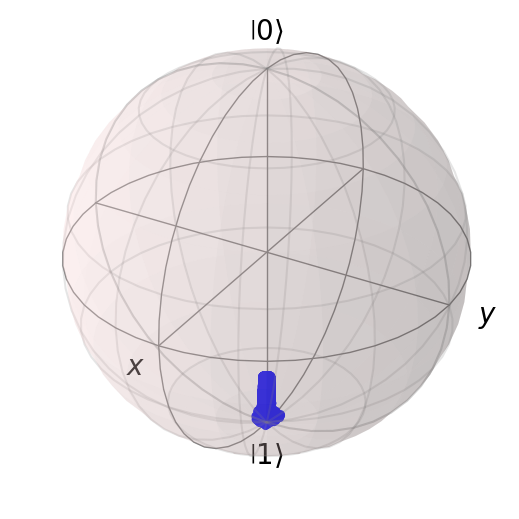

In [137]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

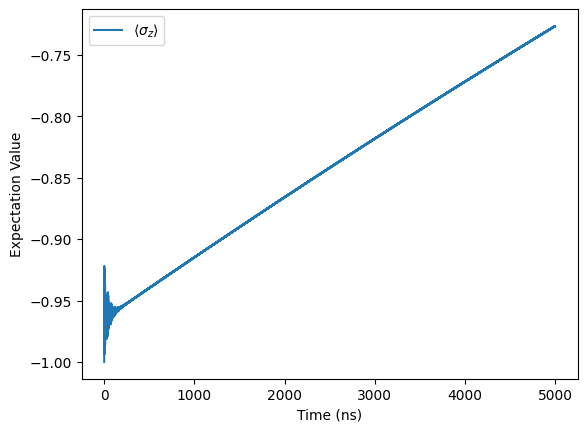

In [138]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [139]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.93849729e+00,  9.73398223e-01,  3.80794172e+04])

## Time Evolution & Purcell Decay Rate

$n=0.009$

In [128]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.001 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.009123734913412862

Text(0, 0.5, 'Photon Number Expectation Value')

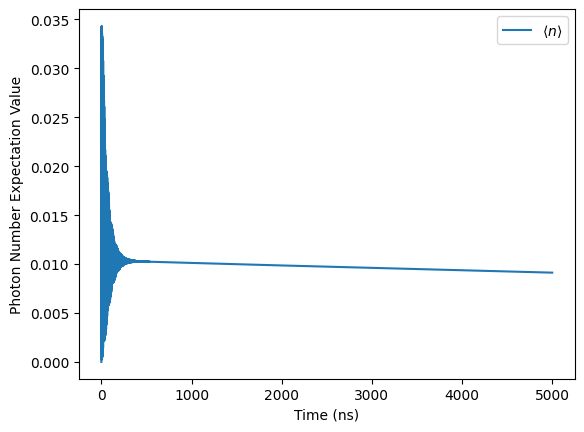

In [129]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

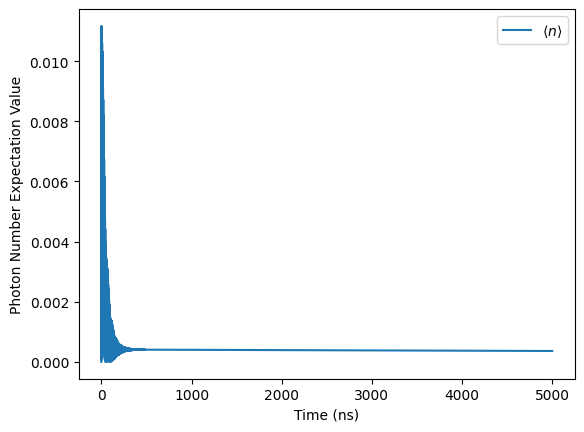

In [130]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

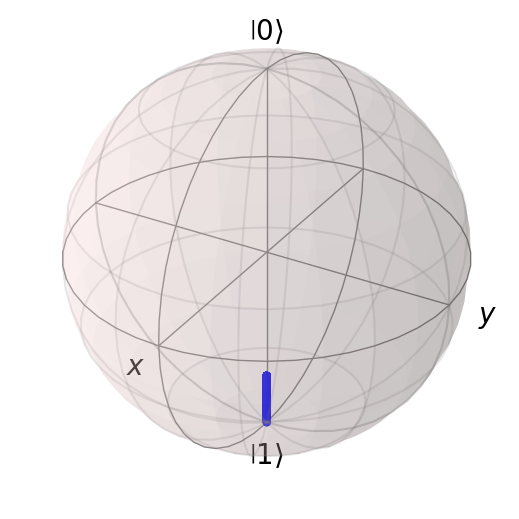

In [131]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

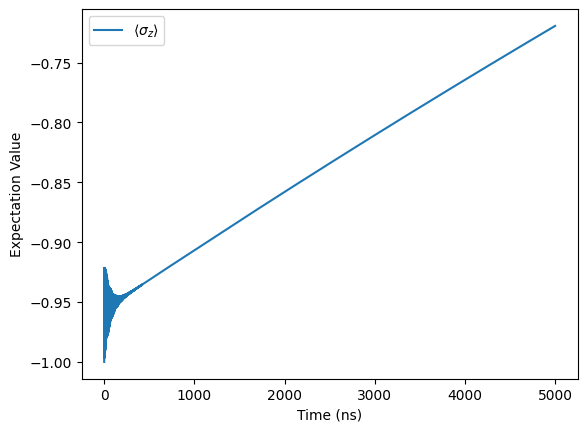

In [132]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [133]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.95662783e+00,  1.00002242e+00,  3.86919330e+04])